<a href="https://colab.research.google.com/github/samibahig/RecoverProject/blob/main/MergingDataset_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
### Salut Etienne, Voici mon code que j'ai utilisé pour concatener mes tables, j'aimerai en discuter avec toi, car il y a des petites différence à la fin, amis j'aimerai discuter de ces datasets de manière générale avec toi

"""
This script extract a data and metadata from the files
it gives dataframes and a labels file
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
data_path = ''


### Ici c'est le code pour lire et nettoyer metadata et qui contient les labels  

#print('\nMETADATA :')
metadata_filename = data_path + '/content/metadata.csv'
meta_df = pd.read_csv(metadata_filename)
#print(meta_df.columns)
meta_df.columns = ['#', 'plate', '-', 'symptoms'] + list(meta_df)[4:]
#print(meta_df.columns)
#print('available metadata :', list(meta_df))
meta_idx = meta_df['ID'].to_list()
meta_label = meta_df['symptoms'].to_list()
#print('------------------')
#print(list(zip(meta_idx, meta_label)))
#print('------------------')
meta_id_label_dict = {str(k): 1 if v=='S' else 0 for k, v in zip(meta_idx, meta_label)}


### Ici  c'est le code pour lire et nettoyer les features de metabolomic

print('\nMETABOLOMICS DATA :')
metabolomics_data_filename = data_path + 'metabolomics.csv'
feat_df = pd.read_csv(metabolomics_data_filename, index_col=0, skiprows=[0], dtype=str, usecols=[0])
features = list(feat_df.index.values)
print('# of features : ', len(features))
print('first feature :', features[0])
print('last feature :', features[-1])
col_list = ["Group"]
column1 = pd.read_csv(metabolomics_data_filename, usecols=col_list)
print('----------')
column1 = column1['Group'].to_list()
print(column1[1:])

print('----------')
idx_df = pd.read_csv(metabolomics_data_filename, header=1, nrows=1, encoding='unicode_escape')

idx = list(idx_df)[1:]
idx = [l[17:22] for l in idx]
labels_df = pd.read_csv(metabolomics_data_filename, nrows=1)
labels = list(labels_df)[1:]
print('# of labels : ', len(labels))

cols_df = pd.read_csv(metabolomics_data_filename, header=1, nrows=1, encoding='unicode_escape')
cols_list = list(cols_df)

df3 = pd.read_csv(metabolomics_data_filename, header=1, na_values=['#DIV/0!'], usecols=cols_list[1:], encoding='unicode_escape')
df3 = df3.T
df3['idx'] = idx
df3.set_index('idx', inplace=True)
df3.columns = features
df3 = df3.dropna(axis=1)

#clean data of samples that are not in metadata :
idx = df3.index.values
y = []
for k in range(len(idx)):
    id = idx[k]
    if id in meta_id_label_dict:
        y.append(meta_id_label_dict[id])
    else:
        # we will not put this sample in the dataset
        #print('sample to remove because of unknown label:', k, id)
        y.append('to_remove')
df3['label'] = y
df3 = df3[df3.label != 'to_remove']

#create X and y matrices for ML :
y = list(df3['label'])
print(y)
del df3['label']
X = df3.to_numpy()

print('metabolomics data :')
print('# of samples : ', df3.shape[0])
print('# of features : ', df3.shape[1])
print('labels:', list(dict.fromkeys(y)))

### Ici c'est le code pour lire le dataset de proteomic

#DF1 : proteomics
#print('\nPROEOMICS DATA :')
proteomics_data_filename = '/content/proteomics.csv'

dim_df = pd.read_csv(proteomics_data_filename, nrows=1)
#print('--------')
#print(dim_df)
#print('--------')
dim = len(list(dim_df))
#print(dim)
#print('------------')
print('# of columns in source csv file :', dim)
all_cols = [i for i in range(dim)]

print('--------')
feat_cols = all_cols[1:-4]
print(feat_cols)
print('--------')
samplesidx_col = [0]

feat_df = pd.read_csv(proteomics_data_filename, skiprows=4, nrows=1, dtype=str, usecols=feat_cols)
features = list(feat_df)
print('# of features : ', len(features))
print('first feature :', features[0])
print('last feature :', features[-1])

idx_df = pd.read_csv(proteomics_data_filename, skiprows=6, index_col=0, skipfooter=4, usecols=[0], engine='python')
idx = list(idx_df.index.values)
print('# of idx : ', len(idx))
print('first id :', idx[0])
print('last id :', idx[-1])

df1 = pd.read_csv(proteomics_data_filename, skiprows=6, dtype=np.float32, skipfooter=4, usecols=feat_cols, engine='python')
assert df1.shape[0] == len(idx)
assert df1.shape[1] == len(features)

df1['idx'] = idx
df1.set_index('idx', inplace=True)
df1.columns = features
print('# of Nan values :', df1.isna().sum().sum())

#clean data of samples that are not in metadata :
idx = df1.index.values
y = []
for k in range(len(idx)):
    id = idx[k]
    if id in meta_id_label_dict:
        y.append(meta_id_label_dict[id])
    else:
        # we will not put this sample in the dataset
        #print('sample to remove because of unknown label:', k, id)
        y.append('to_remove')
df1['label'] = y
df1 = df1[df1.label != 'to_remove']

#create X and y matrices for ML :
y = list(df1['label'])
del df1['label']
print('---------')
print(df1)
print('---------')
X = df1.to_numpy()
print('proteomics data :')
print('# of samples : ', df1.shape[0])
print('# of features : ', df1.shape[1])
print('labels:', list(dict.fromkeys(y)))

### Ici c'est le code pour lire le dataset de proteomic.cyst

# DF 2 : proteomics (cytokines)
print('\nPROTEOMICS CYTOKINES DATA :')
proteomics_cyt_data_filename = data_path + 'proteomics_cyt.csv'

dim_df = pd.read_csv(proteomics_cyt_data_filename, nrows=1)
dim = len(list(dim_df))
print('# of columns in source csv file :', dim)
all_cols = [i for i in range(dim)]
feat_cols = all_cols[1:-2]
samplesidx_col = [0]

feat_df = pd.read_csv(proteomics_cyt_data_filename, skiprows=4, nrows=1, dtype=str, usecols=feat_cols)
features = list(feat_df)
print('# of features : ', len(features))
print('first feature :', features[0])
print('last feature :', features[-1])

idx_df = pd.read_csv(proteomics_cyt_data_filename, skiprows=7, index_col=0, skipfooter=14, usecols=[0], engine='python')
idx = list(idx_df.index.values)
print('# of idx : ', len(idx))
print('first id :', idx[0])
print('last id :', idx[-1])

df2 = pd.read_csv(proteomics_cyt_data_filename, skiprows=7, dtype=np.float32, skipfooter=14, usecols=feat_cols, na_values=['> ULOQ'], engine='python')
assert df2.shape[0] == len(idx)
assert df2.shape[1] == len(features)

df2['idx'] = idx
df2.set_index('idx', inplace=True)
df2.columns = features
print('# of Nan values :', df2.isna().sum().sum())

#clean data of samples that are not in metadata :
idx = df2.index.values
y = []
for k in range(len(idx)):
    id = idx[k]
    if id in meta_id_label_dict:
        y.append(meta_id_label_dict[id])
    else:
        # we will not put this sample in the dataset
        #print('sample to remove because of unknown label:', k, id)
        y.append('to_remove')
df2['label'] = y
df2 = df2[df2.label != 'to_remove']

#create X and y matrices for ML :
y = list(df2['label'])
del df2['label']
X = df2.to_numpy()
print('proteomics_cyt data :')
print('# of samples : ', df2.shape[0])
print('# of features : ', df2.shape[1])
print('labels:', list(dict.fromkeys(y)))

## an option to manage Nan values :
##replace nans with column mean :
##print('replacing nans with column mean')
#for col in list(df2):
#    #print(int(df[col].mean()))
#    df2[col].fillna(int(df2[col].mean()), inplace=True)
#
##print('is there NaN values ? :', df2.isnull().values.any())
##print('# of Nan values :', df2.isna().sum().sum())


## to concatenate the 2 proteomics dataframes if you want : Donc ici le df_1_2 concaténe les deux datasets de Proteomiques
df_1_2 = pd.concat([df1, df2], axis=1)


## to concatenate the 2 proteomics dataframes and the metabolomics if you want : Et ici le df4 concatène le troisième dataset de Métabolomique avec les deux premiers, et le df5 est en plus nettoyé des na sur l'axe zero. 
df4 = pd.concat([df_1_2, df3], axis=1)
df5 = df4.dropna(axis=0)
df4.to_csv(path_or_buf='/content/df4.csv')
df5.to_csv(path_or_buf='/content/df5.csv')
#print('multi-omics df :')
#print('# of samples : ', df.shape[0])
#print('# of features : ', df.shape[1])
#print(df_1_2)

####  Ici c'est un autre type de merge que j'ai fait je t'en parlerai en personne car ça me donne une autre forme de dataset, j'ai concaténé df1 et df2, par contre je n'ai gardé que les lignes qui reviennent dans les deux datasets et j'ai fait un nettoyage un peu différent
#merge_data_filename = '/content/B.merge.csv'
#df_1_2_ = pd.read_csv(merge_data_filename, header=1, encoding='unicode_escape')
#df4_ = pd.concat([df_1_2_, df3], axis=1)


METABOLOMICS DATA :
# of features :  4068
first feature : 3.15_160.1695m/z
last feature : 7.71_483.0063m/z
----------
['3.15_160.1695m/z', '8.56_366.6297m/z', '6.52_828.4067n', '7.23_281.0516m/z', '8.34_429.0893m/z', '4.55_252.0298m/z', '4.56_234.0194m/z', '4.55_220.0590m/z', '5.19_386.0794m/z', '8.56_367.6297m/z', '4.55_337.0498n', '7.68_358.3671m/z', '5.07_371.2588m/z', '5.87_393.0866m/z', '8.34_485.1126m/z', '8.34_445.1197m/z', '4.04_133.0143m/z', '7.68_355.0720m/z', '8.87_519.1391m/z', '4.54_352.0727m/z', '8.34_248.0596m/z', '8.34_355.0706m/z', '5.19_370.2564m/z', '4.78_354.0894m/z', '7.68_371.1045m/z', '9.58_445.1201m/z', '7.68_281.0517m/z', '8.34_281.0516m/z', '8.34_371.1021m/z', '3.24_268.0614m/z', '5.28_429.2386m/z', '7.68_248.0590m/z', '4.04_151.0293m/z', '4.08_284.0562m/z', '8.87_206.0254n', '8.38_207.0326m/z', '6.52_414.2042n', '8.34_223.0674m/z', '4.60_368.0878m/z', '8.87_559.1315m/z', '7.68_190.0325n', '7.68_411.1100m/z', '6.52_119.0859m/z', '5.87_449.1529m/z', '8.87_355.

In [6]:
df_1_2

,Q96SB3,P16278,O75475,Q05516,Q9NWZ3,Q15661,P14317,Q9UHC6,Q6UXB4,Q00978,Q9UNE0,P05231,Q13574,Q8WTT0,P51617,Q9UMR7,Q06830,P30048,P09038,P30044,Q8N608,Q9C035,Q14203,P23229,Q15517,Q14435,Q96DB9,Q12933,P19474,Q8NHJ6,P34130,P08727,O43736,P50135,P51671,Q7Z6M3,Q9GZT9,Q12968,O60449,P63241,...,P60568,Q07325,P01135,P01584,P05231,P05112,O43508,Q969D9,P51671,P14210,P49771,Q96PD4,P13232,P35225,Q14116,Q99616,P50591,P02778,P01579,P22301,Q99731,P01375,P40933,P10147,P10145,P39900,P04141,P09919,P15692,Q9P0M4,P01133,P13500,Q16552,P13725,P09603,P13236,O14625,P01374,P80098,P03956
5-139,1.61741,1.31276,3.20077,1.28369,1.09331,6.31789,3.97440,1.76617,3.13045,1.06086,4.35658,2.18349,0.01726,4.40230,1.02437,3.49416,2.06818,-0.25117,2.23789,3.57209,1.47816,0.59620,4.49329,1.31110,3.37943,1.51654,-0.36669,2.21557,1.48163,2.31041,1.87637,3.01404,2.70897,8.28588,7.69173,2.62717,1.42794,0.34479,1.86133,0.75466,...,0.00310,47.635941,19.602230,0.01838,4.08696,0.02049,841.618408,0.02052,120.033890,655.881409,180.057434,0.04859,5.54881,20.82823,263.500488,122.603554,367.374939,107.925461,0.30287,1.36860,130.272034,19.464350,11.99858,7.40087,10.74015,185.298538,0.28222,84.906326,460.055908,7.508280,440.983765,546.789246,0.18685,11.57456,169.217682,91.573021,45.746799,18.96545,1.89503,3484.805664
1-039,2.79530,2.12398,2.90156,1.55239,1.78039,5.86867,6.34991,1.76211,3.14089,1.84842,3.14027,3.08873,0.61471,5.81175,1.35897,4.14904,1.40836,-0.39399,0.05725,5.10607,1.61865,1.53998,4.34633,1.58021,3.49046,1.85678,0.11872,2.41717,2.46184,2.38954,2.21913,2.22324,2.12394,8.23283,7.73235,3.03961,2.78569,0.19504,2.17033,-1.44591,...,0.01274,20.779289,36.616909,0.13591,7.68976,0.05220,685.445312,0.02987,120.026878,1072.312500,119.730659,0.47567,4.10289,0.29985,246.074997,186.678146,396.559296,51.918732,0.12844,0.59468,99.510788,10.335480,10.15531,6.61970,11.14864,154.318604,0.15098,97.962952,427.589203,12.962800,490.305603,466.596924,0.15477,15.16106,133.400284,195.105377,35.516991,11.14506,0.96097,6607.580078
1-062,1.69202,2.07015,2.07562,0.85847,0.49859,7.75172,4.65479,2.21477,3.04924,1.31301,3.87695,2.45674,-0.01463,4.17340,0.80268,3.60578,1.17825,-0.03338,-0.03244,3.52938,1.55905,1.11615,3.47775,1.80248,3.35451,1.50487,-0.48801,1.89384,2.11849,2.63059,0.89079,2.49999,2.49352,8.58138,7.63120,2.86608,1.88458,-0.13370,2.24601,-1.20606,...,0.02725,59.497871,19.514139,0.13468,3.96441,0.04595,824.847900,0.03021,98.033127,630.983032,180.631180,3.59341,4.22493,0.30544,197.577576,165.572968,611.687622,91.076279,0.23817,0.74935,114.361000,21.534790,11.63106,8.86735,9.76674,221.434616,0.24339,46.792068,540.765198,32.226620,572.971863,528.974304,0.71538,7.18436,130.322983,307.713379,45.269112,7.55923,0.78187,5634.889160
1-040,1.62496,1.67346,2.30191,1.09831,0.81814,6.64685,4.33614,2.09165,3.05241,2.20853,2.26132,2.50169,0.23786,4.26749,0.64027,3.49041,1.65639,0.18282,-0.00258,4.99097,2.04746,0.91502,3.26891,2.64068,3.40662,1.75302,0.12112,1.84230,2.36297,2.11362,1.17813,3.05439,1.92376,9.62026,8.21851,2.76462,1.76014,2.25881,2.59258,-0.81823,...,0.02938,87.222717,8.429850,0.03051,5.64413,0.01686,704.850830,0.01658,170.408234,466.698486,115.245522,4.90308,6.88300,0.63191,259.299469,194.000763,774.570129,172.864975,0.52656,0.95139,174.726715,21.806391,13.05225,15.51203,12.51854,358.068176,0.26974,85.968040,502.535706,8.032540,321.303650,609.924683,0.22472,3.80081,138.496109,133.964890,62.910141,14.23622,1.35255,879.061279
2-044,1.69246,1.94635,1.87725,0.84233,0.94892,6.58968,4.16511,2.40432,3.00726,1.50699,2.12517,2.29901,0.24841,5.03193,1.01317,3.90652,1.23097,-0.57250,0.13042,3.71696,1.81006,0.74829,3.20420,1.64555,3.67404,2.16357,-0.21364,1.48885,1.95872,2.31918,0.96196,4.42944,3.61034,8.32843,8.55660,3.11959,1.68008,-0.13158,2.67852,-0.90111,...,0.01746,62.933498,21.922319,0.03919,3.44706,0.01637,985.487000,0.08656,197.391296,554.511536,187.895721,0.26544,8.42310,0.20485,189.365906,220.105560,621.106506,112.907173,0.24312,0.65627,93.682327,15.223610,10.60110,9.74099,9.03977,217.91

In [13]:
df4

,Q96SB3,P16278,O75475,Q05516,Q9NWZ3,Q15661,P14317,Q9UHC6,Q6UXB4,Q00978,Q9UNE0,P05231,Q13574,Q8WTT0,P51617,Q9UMR7,Q06830,P30048,P09038,P30044,Q8N608,Q9C035,Q14203,P23229,Q15517,Q14435,Q96DB9,Q12933,P19474,Q8NHJ6,P34130,P08727,O43736,P50135,P51671,Q7Z6M3,Q9GZT9,Q12968,O60449,P63241,...,0.48_666.7421m/z,10.61_741.8742m/z,10.63_1003.5049m/z,8.20_450.3441n,0.48_578.7227n,0.49_993.2909m/z,5.68_261.0367m/z,7.10_501.8374m/z,8.62_1127.7236m/z,10.63_947.4835n,0.49_853.5551n,0.48_635.2662m/z,0.49_870.4804m/z,9.82_280.2622m/z,0.49_887.4808n,9.88_113.1328m/z,0.49_891.5109n,3.89_740.4623m/z,5.44_329.2156m/z,7.14_277.2118m/z,0.49_723.5430n,0.48_640.2781m/z,5.04_368.0926m/z,0.49_1073.2289n,0.49_1055.2488n,4.15_381.0763m/z,0.49_993.2841n,6.65_444.2716n,9.88_219.9900m/z,6.96_578.8848m/z,7.91_456.2729n,7.76_427.3881m/z,7.94_253.2515m/z,10.56_741.8400n,0.43_275.8879m/z,0.49_1030.2676m/z,0.49_765.5065n,9.19_306.2746m/z,0.49_1047.2211n,7.71_483.0063m/z
5-139,1.61741,1.31276,3.20077,1.28369,1.09331,6.31789,3.97440,1.76617,3.13045,1.06086,4.35658,2.18349,0.01726,4.40230,1.02437,3.49416,2.06818,-0.25117,2.23789,3.57209,1.47816,0.59620,4.49329,1.31110,3.37943,1.51654,-0.36669,2.21557,1.48163,2.31041,1.87637,3.01404,2.70897,8.28588,7.69173,2.62717,1.42794,0.34479,1.86133,0.75466,...,-121.036,0,5.01551,298.061,-199.755,428.099,0.00408361,-1.81591,-96.6976,13.492,-18.5142,10.2051,-66.6011,120.08,-54.822,-3.98438,-43.2713,13.0451,13556.3,80.4299,-58.7721,1.30156,0,212.437,352.119,8.15299,112.352,-1032.61,6.83299,-11.0247,8060.2,-8.09393,54.5622,-0.285714,6.05802,340.154,-97.7138,3.51004,-318.616,0
1-039,2.79530,2.12398,2.90156,1.55239,1.78039,5.86867,6.34991,1.76211,3.14089,1.84842,3.14027,3.08873,0.61471,5.81175,1.35897,4.14904,1.40836,-0.39399,0.05725,5.10607,1.61865,1.53998,4.34633,1.58021,3.49046,1.85678,0.11872,2.41717,2.46184,2.38954,2.21913,2.22324,2.12394,8.23283,7.73235,3.03961,2.78569,0.19504,2.17033,-1.44591,...,-142.368,0,0,318.969,-278.971,409.433,0.14105,-5.80701,-126.741,1.22361,-20.9241,12.5577,-82.2576,126.548,-63.1611,-4.08768,-55.0368,14.6141,2814.16,141.238,-72.2161,1.60186,0.0723111,258.665,437.024,18.295,146.787,-2609.8,5.96227,-17.9965,6807.58,-7.36432,69.9878,-3.69142,6.03902,461.97,-116.377,3.80319,-447.032,0
1-062,1.69202,2.07015,2.07562,0.85847,0.49859,7.75172,4.65479,2.21477,3.04924,1.31301,3.87695,2.45674,-0.01463,4.17340,0.80268,3.60578,1.17825,-0.03338,-0.03244,3.52938,1.55905,1.11615,3.47775,1.80248,3.35451,1.50487,-0.48801,1.89384,2.11849,2.63059,0.89079,2.49999,2.49352,8.58138,7.63120,2.86608,1.88458,-0.13370,2.24601,-1.20606,...,-85.2662,-1.15974,2.26596,259.831,-154.561,1169.12,0.0160008,-1.39355,-63.4903,11.7791,-2.71773,5.63256,-27.6883,101.861,-15.2767,-1.69926,-15.9039,9.99437,-1252.94,136.006,-21.4596,1.48311,0,104.761,214.55,3.85162,51.1418,-793.408,4.61585,-4.31439,6624.63,-2.72982,41.8964,-0.202489,4.19682,244.909,-37.6987,1.46299,-197.965,0.256787
1-040,1.62496,1.67346,2.30191,1.09831,0.81814,6.64685,4.33614,2.09165,3.05241,2.20853,2.26132,2.50169,0.23786,4.26749,0.64027,3.49041,1.65639,0.18282,-0.00258,4.99097,2.04746,0.91502,3.26891,2.64068,3.40662,1.75302,0.12112,1.84230,2.36297,2.11362,1.17813,3.05439,1.92376,9.62026,8.21851,2.76462,1.76014,2.25881,2.59258,-0.81823,...,-79.6712,-2.10367,1.30704,159.522,-155.629,2242.98,0.0233822,-0.362409,-71.8828,9.70973,-29.959,2.67787,-78.364,78.6892,-69.4807,-1.22712,-53.326,8.52271,-1252.23,71.0503,-70.8111,0.751246,0.0141983,164.793,270.183,5.32192,61.7502,-915.569,3.39388,-7.59302,7476.56,-2.5729,44.8265,-3.08689,4.03408,262.515,-113.691,2.61473,-275.009,0.120222
2-044,1.69246,1.94635,1.87725,0.84233,0.94892,6.58968,4.16511,2.40432,3.00726,1.50699,2.12517,2.29901,0.24841,5.03193,1.01317,3.90652,1.23097,-0.57250,0.13042,3.71696,1.81006,0.74829,3.20420,1.64555,3.67404,2.16357,-0.21364,1.48885,1.95872,2.31918,0.96196,4.42944,3.61034,8.32843,8.55660,3.11959,1.68008,-0.13158,2.67852,-0.90111,...,-77.7895,-0.23364,2.77033,204.839,-167.125,647.855,0.0178223,-2.86809,-90.2193

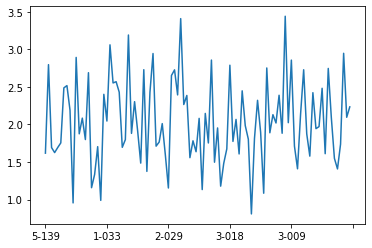

In [14]:
df4['Q96SB3'].plot()

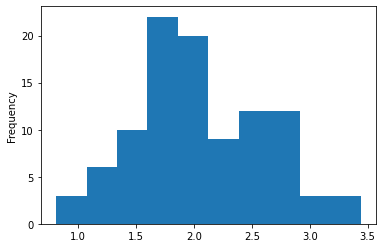

In [30]:
df4['Q96SB3'].plot(kind = "hist")

In [31]:
meta_df

,#,plate,-,symptoms,ID,Age,Time since infection,Fever,cough,difficulty breathing,chest pain,fatigue,myalgia,sore throat,headache,dizziness,anosmia,agueusia,nasal congestion,diarrhea,nausea,vomitting,abdominal pain,Loss of appetite,other,specify,Residual Fever,Residual cough,Residual difficulty breathing,Residual chest pain,Residual fatigue,Residual myalgia,Residual sore throat,Residual headache,Residual dizziness,Residual anosmia,Residual agueusia,Residual nasal congestion,Residual diarrhea,Residual nausea,Residual vomitting,Residual abdominal pain,Resdiual loss of appetite,Residual other,addition,specify.1
0,1,Plate 1,A1,S,5-139,42.27,1.30,0,1,0,0,1,0,1,1,0,1,1,1,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Plate 1,A3,S,1-062,55.95,4.50,1,0,1,0,1,0,0,1,1,1,1,0,0,0,0,0,1,1,loss of energy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,Stress
2,3,Plate 1,A4,S,1-040,58.37,4.80,1,0,1,0,1,1,0,1,0,1,1,0,0,1,1,0,0,1,shortness of breath,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0,"back pain is worse, shortness of breath"
3,4,Plate 1,A5,S,2-044,64.31,5.03,1,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,impression of a foreigh body stuck in throat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,Impression of a foreingh body in throat
4,5,Plate 1,B1,S,5-160,57.52,1.90,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Pneumonia,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100,Plate 2,E4,NS,5-047,42.09,6.93,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,"epidermal sensitivity, hair loss",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,101,Plate 2,F3,NS,3-039,56.52,6.53,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,102,Plate 2,F5,NS,1-107,53.93,7.40,1,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,1,active smell of metal of everything,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,103,Plate 2,G2,NS,2-043,46.07,6.03,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,burning sensation in chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
metadatas = pd.read_csv("/content/df1_Metadatas_Presentation.csv")

In [36]:
metadatas['Age'].plot(kind = "hist")

,ID,CovidSymptoms,Age,Time since infection,Fever,cough,difficulty breathing,chest pain,fatigue,myalgia,sore throat,headache,dizziness,anosmia,agueusia,nasal congestion,diarrhea,nausea,vomitting,abdominal pain,Loss of appetite,other,specify,Residual Fever,Residual cough,Residual difficulty breathing,Residual chest pain,Residual fatigue,Residual myalgia,Residual sore throat,Residual headache,Residual dizziness,Residual anosmia,Residual agueusia,Residual nasal congestion,Residual diarrhea,Residual nausea,Residual vomitting,Residual abdominal pain,Resdiual loss of appetite,Residual other,addition,specify.1
0,5-139,S,42.27,1.30,0,1,0,0,1,0,1,1,0,1,1,1,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1-062,S,55.95,4.50,1,0,1,0,1,0,0,1,1,1,1,0,0,0,0,0,1,1,loss of energy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,Stress
2,1-040,S,58.37,4.80,1,0,1,0,1,1,0,1,0,1,1,0,0,1,1,0,0,1,shortness of breath,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0,"back pain is worse, shortness of breath"
3,2-044,S,64.31,5.03,1,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,impression of a foreigh body stuck in throat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,Impression of a foreingh body in throat
4,5-160,S,57.52,1.90,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Pneumonia,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5-047,NS,42.09,6.93,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,"epidermal sensitivity, hair loss",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,3-039,NS,56.52,6.53,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,1-107,NS,53.93,7.40,1,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,1,active smell of metal of everything,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2-043,NS,46.07,6.03,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,burning sensation in chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


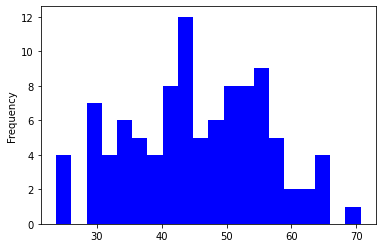

In [45]:
metadatas['Age'].plot(kind = "hist", bins= 20, color = 'blue')

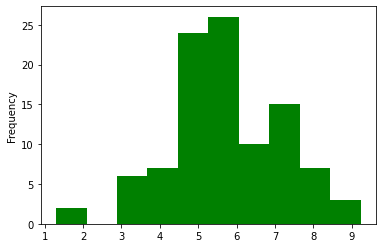

In [44]:
metadatas['Time since infection'].plot(kind = "hist", bins= 10, color = 'green')

In [15]:
df1.plot(kind = 'scatter', x = "index", y = "Proteins")

,Q96SB3,P16278,O75475,Q05516,Q9NWZ3,Q15661,P14317,Q9UHC6,Q6UXB4,Q00978,Q9UNE0,P05231,Q13574,Q8WTT0,P51617,Q9UMR7,Q06830,P30048,P09038,P30044,Q8N608,Q9C035,Q14203,P23229,Q15517,Q14435,Q96DB9,Q12933,P19474,Q8NHJ6,P34130,P08727,O43736,P50135,P51671,Q7Z6M3,Q9GZT9,Q12968,O60449,P63241,...,P29460,Q13007,P35225,Q5T4W7,P09238,P22301.1,P01375,P55773,P06127,P10147,P49771,P80162,P02778,Q13541,Q9NYY1,Q8IXJ6,Q9NRJ3,Q8NFT8,P80511,P25942,O95760,P01579,O95750,P05112,P15018,Q99748,P80075,Q14790,O15444,P78423,Q07011,P20783,O43508,P78556,P50225,O95630,P05113.1,P00813,P01374,P09603
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5-139,1.61741,1.31276,3.20077,1.28369,1.09331,6.31789,3.97440,1.76617,3.13045,1.06086,4.35658,2.18349,0.01726,4.40230,1.02437,3.49416,2.06818,-0.25117,2.23789,3.57209,1.47816,0.59620,4.49329,1.31110,3.37943,1.51654,-0.36669,2.21557,1.48163,2.31041,1.87637,3.01404,2.70897,8.28588,7.69173,2.62717,1.42794,0.34479,1.86133,0.75466,...,6.45376,0.54651,3.66350,0.59005,9.64994,2.09417,2.54263,10.71743,6.18578,5.92567,9.70824,8.83603,9.52531,9.32360,0.58280,3.34926,1.82766,8.91739,5.25219,11.37306,0.74535,7.02608,9.70010,-1.25145,-0.19028,0.31890,8.92051,2.40885,6.17665,3.76894,6.70677,1.28331,9.31927,6.40766,2.62781,4.31117,0.12752,5.46542,5.97368,10.40443
1-039,2.79530,2.12398,2.90156,1.55239,1.78039,5.86867,6.34991,1.76211,3.14089,1.84842,3.14027,3.08873,0.61471,5.81175,1.35897,4.14904,1.40836,-0.39399,0.05725,5.10607,1.61865,1.53998,4.34633,1.58021,3.49046,1.85678,0.11872,2.41717,2.46184,2.38954,2.21913,2.22324,2.12394,8.23283,7.73235,3.03961,2.78569,0.19504,2.17033,-1.44591,...,6.80569,0.26686,0.07749,1.09399,8.98418,1.27544,1.55479,10.60056,6.57680,5.91372,9.18510,9.37647,8.68842,7.11640,0.21378,2.83728,1.80182,8.85772,7.33199,11.63727,0.69003,5.81130,9.97359,-0.39812,-0.42401,0.32376,10.24353,3.73741,5.52369,3.78179,6.39291,1.72040,9.16705,6.54110,3.40565,3.77362,0.88631,5.24029,5.07646,10.14180
1-062,1.69202,2.07015,2.07562,0.85847,0.49859,7.75172,4.65479,2.21477,3.04924,1.31301,3.87695,2.45674,-0.01463,4.17340,0.80268,3.60578,1.17825,-0.03338,-0.03244,3.52938,1.55905,1.11615,3.47775,1.80248,3.35451,1.50487,-0.48801,1.89384,2.11849,2.63059,0.89079,2.49999,2.49352,8.58138,7.63120,2.86608,1.88458,-0.13370,2.24601,-1.20606,...,7.41703,2.21376,0.52045,0.20417,9.34233,1.58197,2.63448,10.87051,6.10416,6.40068,9.71860,8.58336,9.42456,6.54315,0.07419,1.93169,2.22637,8.92353,6.03559,11.46210,0.10663,6.63798,9.88982,-0.33260,-0.65862,0.25081,8.32464,2.97773,6.02093,4.69840,6.94436,1.24940,9.51528,7.85878,3.36113,3.62268,0.18121,5.34243,4.89149,10.02279
1-040,1.62496,1.67346,2.30191,1.09831,0.81814,6.64685,4.33614,2.09165,3.05241,2.20853,2.26132,2.50169,0.23786,4.26749,0.64027,3.49041,1.65639,0.18282,-0.00258,4.99097,2.04746,0.91502,3.26891,2.64068,3.40662,1.75302,0.12112,1.84230,2.36297,2.11362,1.17813,3.05439,1.92376,9.62026,8.21851,2.76462,1.76014,2.25881,2.59258,-0.81823,...,6.08501,-0.56488,1.73170,0.74454,9.68228,1.93269,2.73308,10.41954,5.96877,7.04689,9.03384,9.65598,10.34459,6.66414,1.82124,2.15148,1.89673,9.18380,5.70352,11.96275,0.52976,7.64641,9.57866,-0.25246,-0.22653,-0.18848,9.81806,2.98370,6.85855,3.73308,7.34728,2.89403,9.26371,6.76841,3.24928,3.73208,2.11383,5.54121,5.57492,10.13417
2-044,1.69246,1.94635,1.87725,0.84233,0.94892,6.58968,4.16511,2.40432,3.00726,1.50699,2.12517,2.29901,0.24841,5.03193,1.01317,3.90652,1.23097,-0.57250,0.13042,3.71696,1.81006,0.74829,3.20420,1.64555,3.67404,2.16357,-0.21364,1.48885,1.95872,2.31918,0.96196,4.42944,3.61034,8.32843,8.55660,3.11959,1.68008,-0.13158,2.67852,-0.90111,...,7.21859,0.29590,-0.04191,0.29989,9.42529,1.35058,2.26556,10.63873,5.80235,6.38692,9.78636,9.48285,9.68067,5.97848,0.42871,1.45627,2.25108,9.10119,5.46424,11.54372,0.57656,6.38148,9.75322,-0.50087,0.09614,0.37705,10.24673,3.80502,6.78487,4.50189,6.62294,1.72170,9.65417,7.03946,2.19029,3.23768,0.60991,4.98001,4.80933,10.04586
...,...,...,...,...,...,...,...,...,...,...,...,..

In [22]:
df1.index, df1.columns

(Index(['5-139', '1-039', '1-062', '1-040', '2-044', '2-050', '1-026', '5-160',
        '1-057', '2-026', '1-098', '1-037', '1-103', '1-070', '1-010', '2-030',
        '2-022', '1-035', '2-032', '1-101', '1-033', '1-063', '1-020', '1-009',
        '1-045', '2-052', '1-013', '1-003', '2-008', '2-055', '2-012', '2-064',
        '1-030', '1-058', '1-034', '1-095', '1-093', '2-085', '1-060', '1-025',
        '2-029', '2-077', '1-042', '3-023', '1-031', '1-006', '1-018', '2-013',
        '2-033', '2-031', '2-083', '2-059', '2-068', '2-106', '5-078', '3-021',
        '3-045', '1-100', '2-079', '2-086', '3-018', '5-059', '3-005', '5-152',
        '5-027', '3-006', '5-128', '2-096', '2-069', '3-044', '1-087', '1-069',
        '3-002', '5-033', '5-060', '2-113', '2-027', '3-032', '3-007', '5-047',
        '3-009', '5-147', '2-074', '1-080', '3-039', '1-105', '1-107', '5-125',
        '1-088', '2-043', '5-067', '2-088', '5-096', '5-089', '2-015', '1-073',
        '2-108', '5-114', '5-075', '3-04

KeyError: ignored

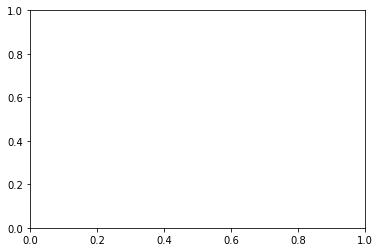

In [29]:
%matplotlib inline
df1.plot(kind ="scatter", x = "Index", y = "columns")